# Introduction To Reinforcement Learning: The Multi-Armed Bandit Problem
## Chris Tralie

We discussed the multi-armed bandit problem in class today.  This is the starting point for <b>reinforcement learning</b>, or learning how to behave in some <b>environment</b> over time.

In the basic version of the multi-armed bandit problem problem, we have $N$ slot machines, each with a different *fixed* probability distribution of the amount of payout they have each time we "pull" on them.  We don't know how they behave going in, and our job is to maximize the payout over some number of pulls of the bandits.  In particular, we need to come up with a <b>policy</b> (a set of actions to take over time) that maximizes the <b>reward</b> (in this case, the cumulative sum of all amounts of money we get at each pull).  The trick is, since we don't know anything about the bandits, we have to learn and update our policy over time as we explore and get more information about the <b>value</b> (long term behavior) of each machine.

Before we dive in, we should note that this is much generally applicable than just slot machines!  Here are some other examples where exploring an environment and learning a "multi-armed bandit" policy would apply, including some people came up with in class:


<table>
    <tr><td></td><td>Environment</td><td>Policy over time</td><td>Reward</td></tr>
    <tr><td>Slot Machines<td>Slot machines with different payouts</td><td>Which machine to pull</td><td>Money accrued</td></tr>
    <tr><td>Fishing (Kacey)</td><td>Different densities of fish in different places</td><td>Where to fish</td><td>Total fish caught</td></tr>
    <tr><td>Efficient driving</td><td>Performance of car</td><td>How fast to drive</td><td>Miles per gallon</td></tr>
    <tr><td>Coal mining (Breeze)</td><td>Quality of coal in different areas</td><td>Which areas to mine</td><td>Total coal mined, factoring in quality</td></tr>
</table>


But for the rest of this example, we'll stick to the "one-armed bandit" analogy of a slot machine.  First, let's define what a bandit is in code, and then we'll talk more about how to learn different policies for this problem.

We're going to use a class called "Bandit" to encapsulate what it means to be a bandit.  For the probability distributions, we'll pick numbers uniformly at random between 0 and some maximum value for each bandit.  The maximum value is the hidden parameter.  We'll "seed" the maximum value so that it seems to be randomly different for each bandit, but so that we all get the same results each time we run it.  This is known as <a href = "https://ursinus-cs174-s2022.github.io/CoursePage/ClassExercises/Week4_Binary_LFSR/#bglfsr">pseudorandomness</a>.  Let's see how we'd define such a class below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
class Bandit:
    def __init__(self, seed):
        """
        The constructor for bandit objects
        
        Parameters
        ----------
        seed: int
            A seed for the pseudorandom number generator.  Different seeds
            will give different values of the max this bandit can give at
            any pull (self.mx)
        """
        
        self.seed = seed
        np.random.seed(seed)
        self.mx = np.random.rand()*10
    
    def pull(self):
        """
        Returns
        -------
        One random pull of this bandit, which returns a number in [0, self.mx]
        """
        return np.random.rand()*self.mx
    
    def __repr__(self):
        return "Bandit seed {}, Max Payout {:.3f}".format(self.seed, self.mx)
    
# Setup a list of 10 bandits and print them out
bandits = [Bandit(i*2) for i in range(10)]
for b in bandits:
    print(b)
results = {}

Bandit seed 0, Max Payout 5.488
Bandit seed 2, Max Payout 4.360
Bandit seed 4, Max Payout 9.670
Bandit seed 6, Max Payout 8.929
Bandit seed 8, Max Payout 8.734
Bandit seed 10, Max Payout 7.713
Bandit seed 12, Max Payout 1.542
Bandit seed 14, Max Payout 5.139
Bandit seed 16, Max Payout 2.233
Bandit seed 18, Max Payout 6.504


In the above list of 10 bandits, we see the one at index 2 has the maximum payout.  So ideally, our policy would be to just pull on that one over and over.  But we don't necessarily know that information going in, so we're going to have to learn it *online* as we're pulling on the bandits.  

Below I'll discuss several strategies for automating good policy discovery.  In each case, the algorithm will trade off <b>exploration</b> vs <b>exploitation</b>.  The more the algorithm tries out the different bandit arms, the more it learns about each one, but the less time it has to exploit (pull on) the one that seems to be doing the best.  By contrast, we can explore very little (e.g. some people in class only pulled on each bandit once at the beginning and then went with the one that paid the most that one time).  But we might then not have correct information about which bandit is the best.

## Epsilon-Greedy Strategy

Our first strategy is known as an $\epsilon$-greedy strategy.  The idea is that an $\epsilon$ proportion of the time, we will explore by randomly choosing a bandit to pull on, and the rest of the time we will pull on the one that has the greatest <i>average</i> payout so far.  The average payout gives our <b>value estimate</b> of the machine; that is, how much it rewards us <i>over time</i>, even if it has some better than average or worse than average pulls at any particular instant.

One strategy for figuring out when to explore is akin to throwing a dart uniformly at random into the unit interval $[0, 1]$ at each pull.  If the dart is in the interval $[0, \epsilon]$, then we will choose to pull a bandit at random.  Otherwise, we will pull on the one that has the highest average payout so far.  The picture below depicts this, where the red dots choose to randomly explore and the blue dots when it chooses to pull the one it thinks is the best so far:

<img src = "EpsDarts.svg" width="50%">

Let's write some code to execute this strategy on some list of bandits for some number of pulls, and we'll test it out for $\epsilon = 0.1$, or exploring 10% of the time and exploiting 90% of the time.  Actually, I'm going to write the code in a very general purpose way so we can use it for other strategies, as explained in the comments

### A note on updating averages

For a particular bandit that's been pulled $n$ times with payouts $x_1, x_2, ..., x_n$, the average payout $\mu_n$ is

## $\mu_n = \frac{x_1 + x_2 + ... + x_n}{n}$

We could update this in constant time by keeping track of two variables: one that accumulates the sum of all pull rewards (the numerator), and one that keeps track of how many pulls have been made (the denominator).  This is the way I did it in class to save time.  But there's a more elegant and illuminating way to compute this (which also avoids the divide by zero issue we saw when no pulls had happened yet).  Let's re-arrange the average equation to understand the impact of a single new observation and how it "reinforces" our previous value estimate.  Note that we can write the following recurrence:

## $\mu_{n} = \frac{(n-1) \mu_{n-1} + x_n}{n}$

If we distribute through the $(n-1)$ in the numerator, we can simplify this to

## $\mu_{n} = \mu_{n-1} + \frac{1}{n} (x_n - \mu_{n-1}) $

An even more general way to write this is:

## $\mu_{n} = \mu_{n-1} + \alpha (x_n - \mu_{n-1}) $

where $\alpha$ is referred to as the "learning rate" in machine learning parlance, or "step size" in optimization parlance.  We will see this paradigm often in this class; we will update some estimate of something we have given new data, and we have to decide how much importance to place on this data.  If $\alpha$ is higher, then we pull our estimate towards this new data much more rapidly.  In our case, since we insisted in computing the mean over time, $\alpha$ decays as we have more pulls; the more data we have, the less an additional observation can affect our value estimate so far.  And eventually, in the limit, it won't affect our estimate; this is the <a href = "https://en.wikipedia.org/wiki/Law_of_large_numbers">law of large numbers</a>.

In the code below, I will leave $\alpha$ open as a function, which defaults to $\frac{1}{n}$, but we'll see a reason later why we might want to change this.


4547.278733183436


Text(0.5, 1.0, 'Bandit Choices')

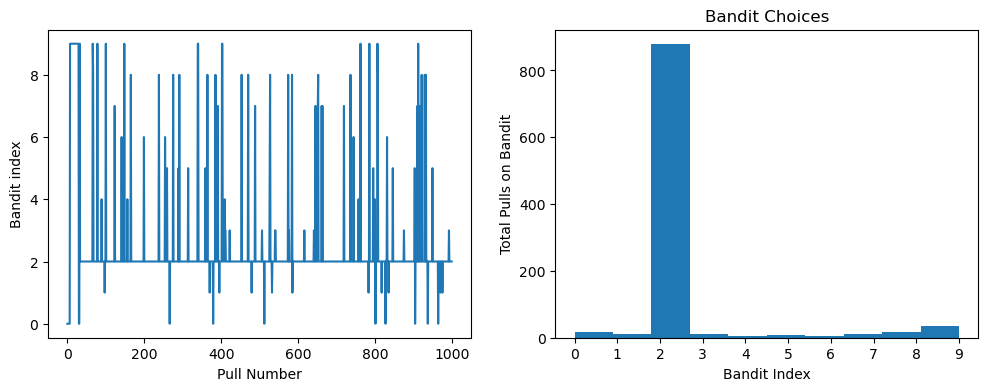

In [3]:
def learn_bandit(bandits, total_pulls, eps_fn, alpha_fn=lambda n: 1/n, bias=0):
    """
    A general purpose method for learning policies for the multi-armed bandit problem
    
    Parameters
    ----------
    bandits: list of Bandit
        The bandits that we can pull on
    total_pulls: int
        Number of pulls to execute
    eps_fn: float OR method pull -> pull probability
        The probability that we will explore at a particular pull
        or exploit at a particular pull, where pull is the number pull we're on.
        * If a float is passed along, this is a constant, and we refer to this
        as an "epsilon_greedy" strategy
        * If a method is passed along, then this can vary as additional pulls happen
    alpha_fn: method pull_num -> float
        A method that gives us "step size" or "learning rate" when integrating a new
        pull's reward into our value estimate.  If we're taking an average of all pulls on
        that machine over time, this will simply be 1/pull_num.  
    bias: float
        The amount of bias to add to the initial estimate of each average value
    
    Returns
    -------
    total_reward: float
        The total reward we got after all pulls
    choices: ndarray(total_pulls, dtype=int)
        The index of the bandit chosen at each pull over time
    """
    from types import FunctionType
    if not isinstance(eps_fn, FunctionType):
        # If the user passed along a constant for the eps_fn, wrap
        # a method around it that always returns that constant
        eps = 1.0*eps_fn
        eps_fn = lambda x: eps
        
    if not isinstance(alpha_fn, FunctionType):
        # If the user passed along a constant for the alpha_fn, wrap
        # a method around it that always returns that constant
        alpha = 1.0*alpha_fn
        alpha_fn = lambda x: alpha
        
    n_bandits = len(bandits)
    total_reward = 0
    # Create an array of all 0's which stores how many pulls have been taken at each bandit
    pull_nums = np.zeros(n_bandits)    
    # Create an array of all 0's which stores the average payout of each bandit so far,
    # which we consider our "value estimate" of that bandit
    values = np.zeros(n_bandits) 
    # Create an array of all 0's stores the index of the bandit chosen at each pull
    choices = np.zeros(total_pulls)   
    
    # If there's a bias, pretend every bandit had one pull with this amount when
    # we start out
    if bias > 0:
        pull_nums[:] = 1
        values[:] = bias
    
    for pull in range(total_pulls):
        ## Step 1: Choose which bandit to pull
        dart = np.random.rand() # Choose number in [0, 1]
        if dart <= eps_fn(pull):
            # If this number is in [0, eps_fn(pull)], choose a random bandit
            idx = np.random.randint(n_bandits)
        else:
            # Otherwise, choose bandit which has maximum avg payout so far
            idx = np.argmax(values)
        
        ## Step 2: Pull the bandit that we intend to pull, and update our
        ## value estimate for that bandit
        this_pull = bandits[idx].pull()
        total_reward += this_pull
        pull_nums[idx] += 1
        # Our update equation: value = value + alpha*(this_pull - value)
        values[idx] = values[idx] + alpha_fn(pull_nums[idx])*(this_pull - values[idx])
        choices[pull] = idx
    
    return total_reward, choices


# We'll start by trying an "epsilon-greedy" strategy with a fixed epsilon of 0.1
plt.figure(figsize=(12, 4))
np.random.seed(0)
total_reward, choices = learn_bandit(bandits, total_pulls=1000, eps_fn=0.1)
print(total_reward)

plt.subplot(121)
plt.plot(choices)
plt.xlabel("Pull Number")
plt.ylabel("Bandit index")
plt.subplot(122)
plt.hist(choices)
plt.xticks(np.arange(len(bandits)))
plt.xlabel("Bandit Index")
plt.ylabel("Total Pulls on Bandit")
plt.title("Bandit Choices")

We see here that we got a pretty decent payout, and it seems to have picked the bandit with the highest payout most of the time, but if you run this cell multiple times with different seeds, you'll see different results.  What we should really do is setup an experiment where we repeat this many times for different numbers pulls for different $\epsilon$ values, and then take the average for each $\epsilon$ for each number of pulls to get an idea of the overall behavior.  Let's explore this below.  We'll setup a dictionary to keep track of the results, where they key is the plot legend (what $\epsilon$ was used), and the value is an array of the average reward for different numbers of pulls.  This will make it convenient for us to plot all of the results as we vary $\epsilon$

In [4]:
# Try these different numbers of pulls.  We'll space the numbers out more as we get larger
# to save time
total_pulls = np.array(np.round(20000*np.linspace(0.01, 1, 500)**2), dtype=int)

# How many experiments to run for each epsilon for each number of pulls.
# We'll take the average over all of these experiments
n_experiments = 200 

for eps in [0, 0.01, 0.1, 0.4]:
    # Start out with an array of zeros to keep track of the average payout at each number
    avg_reward = np.zeros_like(total_pulls) 
    # We'll also save the bandits that are chosen at each step
    all_choices = []
    for i, pulls in enumerate(total_pulls):
        ipd.clear_output()
        print(eps, total_pulls[i])
        # For each number of pulls, run some number of experiments
        reward = 0
        choices = []
        for j in range(n_experiments):
            reward_j, choices_j = learn_bandit(bandits, total_pulls=pulls, eps_fn=eps)
            reward += reward_j
            choices = np.concatenate((choices, choices_j))
        avg_reward[i] = reward/n_experiments
        all_choices.append(choices)

    results["Greedy $\\epsilon = {}$".format(eps)] = {"reward":avg_reward, "choices":all_choices}

0.4 20000


Now let's plot the results!  For the average reward, I'll plot them twice; once to zoom in on a smaller number of pulls up to 1000, and once to plot all the way up to 20,000 pulls

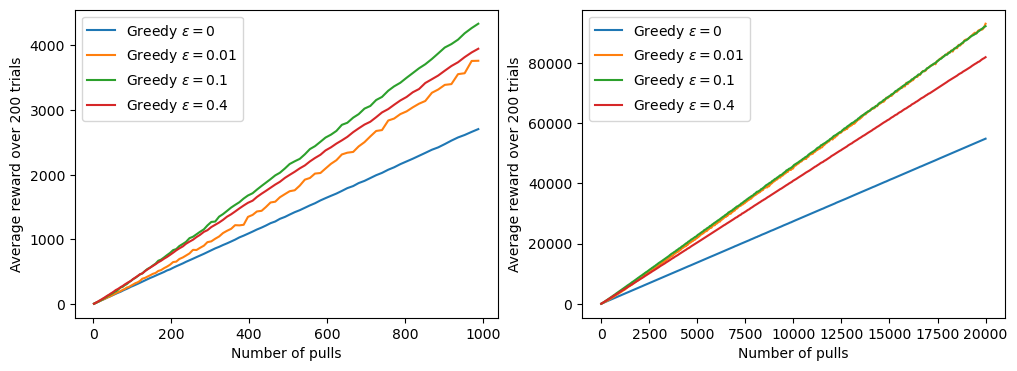

In [5]:
def plot_avg_rewards(total_pulls, results, mn, mx):
    """
    Make a plot of the average rewards vs number of pulls in 
    some range
    mn: min number of pulls
    mx: max number of pulls
    """
    for key in results.keys():
        idx = (total_pulls <= mx)*(total_pulls >= mn)
        plt.plot(total_pulls[idx], results[key]["reward"][idx])
        plt.legend(list(results.keys()))
        plt.xlabel("Number of pulls")
        plt.ylabel("Average reward over {} trials".format(n_experiments))
        
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_avg_rewards(total_pulls, results, 0, 1000)
plt.subplot(122)
plot_avg_rewards(total_pulls, results, 0, np.max(total_pulls))

Let's also look at the choices that were made over time

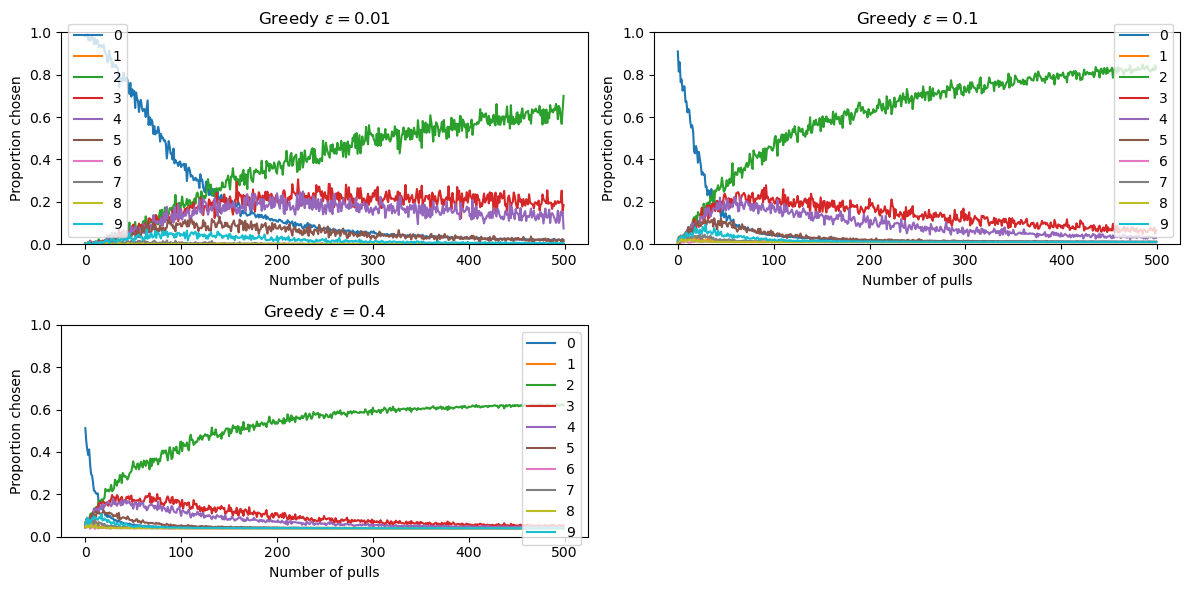

In [6]:
def plot_choices(total_pulls, results, key):
    """
    Make a plot of the proportion of times each bandit was chosen
    """
    prop = [[np.sum(results[key]["choices"][p] == k) 
             for p in range(len(total_pulls))] 
             for k in range(len(bandits))]
    prop = np.array(prop)
    prop = prop/np.sum(prop, axis=0, keepdims=True)
    for k in range(len(bandits)):
        plt.plot(prop[k, :])
    plt.legend(["{}".format(i) for i in range(len(bandits))])
    plt.title(key)
    plt.xlabel("Number of pulls")
    plt.ylabel("Proportion chosen")
    plt.ylim([0, 1])

plt.figure(figsize=(12, 6))
plt.subplot(221)
plot_choices(total_pulls, results, "Greedy $\\epsilon = 0.01$")
plt.subplot(222)
plot_choices(total_pulls, results, "Greedy $\\epsilon = 0.1$")
plt.subplot(223)
plot_choices(total_pulls, results, "Greedy $\\epsilon = 0.4$")
plt.tight_layout()

We notice a few interesting things here in this particular example:

* For a smaller number of pulls, $\epsilon = 0.01$ isn't exploring enough and does the worst.  It is also the noisiest, because we explore so little that our data about which bandit is the best is unreliable
* $\epsilon = 0.4$ has very good estimates of which bandit is the best (bandit at index 2) because it explores the most (and is the smoothest curve as a result), but it doesn't exploit enough.
* For a smaller number of pulls, $\epsilon = 0.1$ seems to perform the best, and it is in the middle with noise
* Eventually for enough pulls, $\epsilon = 0.01$ catches up to $\epsilon=0.1$

So we want explore just enough but not too much.  What is the optimal $\epsilon$?  It depends on the number of bandits and number of pulls, but to get an idea for this specific example, we'll loop through a range of $\epsilon$ values and run a bunch of experiments for 1000 pulls, 5000 pulls, and 10000 pulls:

In [7]:
fixed_pulls = [1000, 5000, 10000]

epsilons = np.linspace(0, 0.5, 51)
n_experiments_eps = 400
avg_rewards_eps = {}
for pulls in fixed_pulls:
    avg_rewards = np.zeros_like(epsilons)
    for i, eps in enumerate(epsilons):
        ipd.clear_output()
        print(pulls, eps)
        reward = 0
        for j in range(n_experiments_eps):
            reward_j, _ = learn_bandit(bandits, total_pulls=pulls, eps_fn=eps)
            reward += reward_j
        avg_rewards[i] = reward/n_experiments_eps
    avg_rewards_eps[pulls] = avg_rewards

10000 0.5


0.04


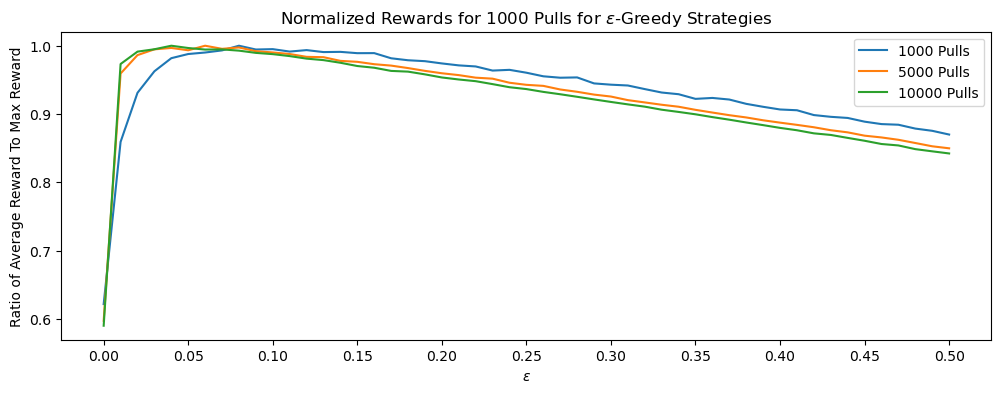

In [8]:
plt.figure(figsize=(12, 4))
for p in fixed_pulls:
    y = avg_rewards_eps[p]/np.max(avg_rewards_eps[p])
    plt.plot(epsilons, y)
plt.legend(["{} Pulls".format(p) for p in fixed_pulls])
plt.xlabel("$\epsilon$")
plt.ylabel("Ratio of Average Reward To Max Reward")
plt.title("Normalized Rewards for 1000 Pulls for $\epsilon$-Greedy Strategies")
plt.xticks(np.linspace(0, 0.5, 11))
print(epsilons[np.argmax(avg_rewards)])


A few theoretical notes:
* For any nonzero epsilon in the limit, by the <a href = "https://en.wikipedia.org/wiki/Law_of_large_numbers">law of large numbers</a>, the estimates of the means we have will eventually converge to the true means.
* By the above logic, in the limit as the number of pulls goes to infinity, smaller epsilons will eventually win out, because their estimates will become very accurate, and they'll spend more time exploring overall.  But we may have to do quite a few pulls for this to happen, so we might want to choose a larger epsilon if we know we won't have as many pulls
* Someone in class was wondering how important it actually was to use the "dart throwing technique" to explore with probability $\epsilon$, rather than doing something more systematic like exploring every $100 \epsilon$ trials, followed by exploiting every $100 (1-\epsilon)$ trials, followed by $100 \epsilon$ more explorations, etc.  It shouldn't actually matter in the long run, but using the probabilistic technique makes it a bit easier to implement and more precise, since $100 \epsilon$ might not be an integer.  It will also make it easier when we vary epsilon, which we'll do in a moment...


## Epsilon-Decay Strategy

Rather than having a fixed epsilon, another strategy is to do a lot of exploration in the beginning but slowly back off and lock in our estimates as we move forward.  We'll use the following equation to change $\epsilon$ for the $t^{\text{th}}$ pull of a particular bandit:

### $\epsilon(t) = \frac{1}{1 + \beta t}$

where $\beta$ is a fixed constant, and larger $\beta$ causes $\epsilon$ to decay faster.  We'll do two experiments below with $\beta = 0.1, 0.01$.  We find that the $\beta = 0.1$ is the best we've seen so far


In [9]:
for beta in [0.1, 0.01]:
    #### New Code
    eps_fn = lambda t: 1/(1 + beta*t) ## Our decaying epsilon method
    ####
    
    # Start out with an array of zeros to keep track of the average payout at each number
    avg_reward = np.zeros_like(total_pulls) 
    # We'll also save the bandits that are chosen at each step
    all_choices = []
    for i, pulls in enumerate(total_pulls):
        ipd.clear_output()
        print(beta, total_pulls[i])
        # For each number of pulls, run some number of experiments
        reward = 0
        choices = []
        for j in range(n_experiments):
            ### New Code
            reward_j, choices_j = learn_bandit(bandits, total_pulls=pulls, eps_fn=eps_fn)
            ###
            reward += reward_j
            choices = np.concatenate((choices, choices_j))
        avg_reward[i] = reward/n_experiments
        all_choices.append(choices)

    results["Decay $\\beta = {}$".format(beta)] = {"reward":avg_reward, "choices":all_choices}

0.01 20000


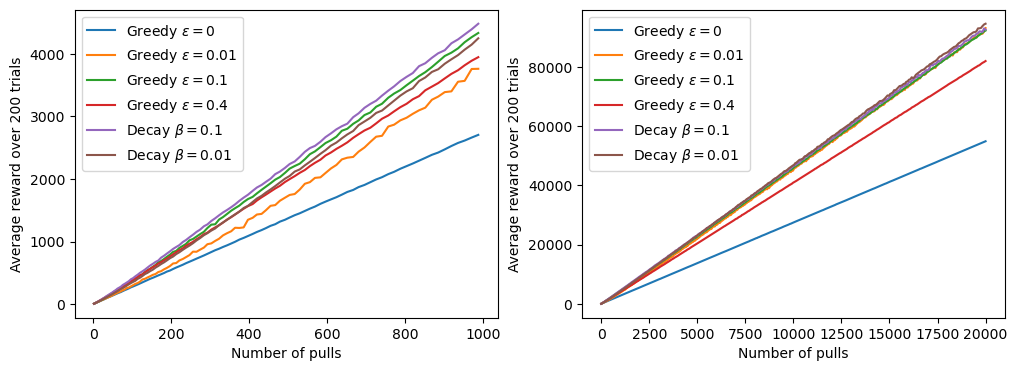

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_avg_rewards(total_pulls, results, 0, 1000)
plt.subplot(122)
plot_avg_rewards(total_pulls, results, 0, np.max(total_pulls))

## Optimistic Strategy

We can actually encourage some exploration even if we keep $\epsilon$ at 0 the whole time!  The way we do this is by over-estimating the value of each machine from the beginning.  We'll start off assuming that each machine has the same high value which is way above the maximum value any machine could have.  Then, even if we pick the best machine, we will be a bit disappointed, and we'll explore others for a bit, until we get even more disappointed by them, eventually coming back to the best machine.  

In code, I call the initial estimate the "bias," because it biases the estimates towards optimism, but this bias eventually goes to zero in the limit as the number of pulls goes to infinity, and, as with any nonzero $\epsilon$, we will converge to the true estimates of the value.

We'll do an experiment below with the bias = 20, which performs the best we've seen so far!  So we can have an even simpler bandit that performs quite well if we always "exploit," assuming we start off very optimistic.  Humans are <a href = "https://freakonomics.com/podcast/heres-why-all-your-projects-are-always-late-and-what-to-do-about-it-rebroadcast/">quite like this in practice</a> as well.

In [11]:
### New Code
bias = 20
###

# Start out with an array of zeros to keep track of the average payout at each number
avg_reward = np.zeros_like(total_pulls) 
# We'll also save the bandits that are chosen at each step
all_choices = []
for i, pulls in enumerate(total_pulls):
    ipd.clear_output()
    print(total_pulls[i])
    # For each number of pulls, run some number of experiments
    reward = 0
    choices = []
    for j in range(n_experiments):
        ### New Code
        reward_j, choices_j = learn_bandit(bandits, total_pulls=pulls, eps_fn=0, bias=bias)
        ###
        reward += reward_j
        choices = np.concatenate((choices, choices_j))
    avg_reward[i] = reward/n_experiments
    all_choices.append(choices)

results["Optimistic, Bias = ${}$".format(bias)] = {"reward":avg_reward, "choices":all_choices}

20000


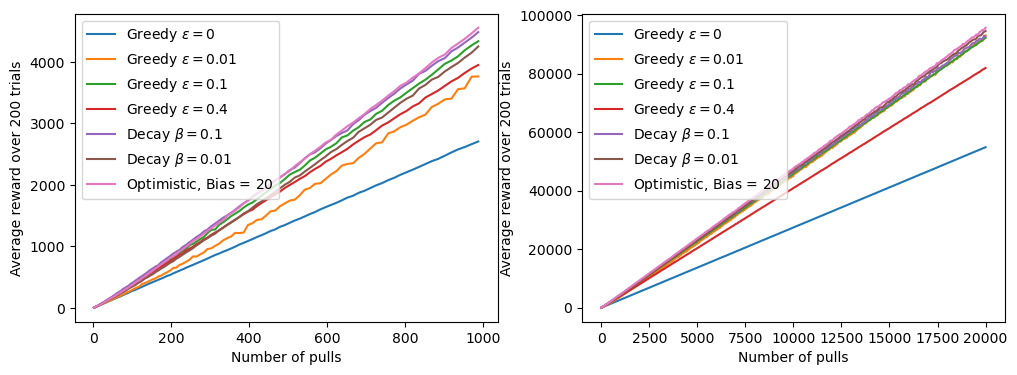

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_avg_rewards(total_pulls, results, 0, 1000)
plt.subplot(122)
plot_avg_rewards(total_pulls, results, 0, np.max(total_pulls))

## Changing Environment

So far, we've only looked at the case where each bandit performs the same each time.  But in real life, the bandits can change their average payout over time.  All of the strategies we've implemented so far assume a fixed environment, so they're not well suited to handle this.  However, I did put something into the bandit strategy to help; the flexibility to choose the learning rate $\alpha$ in the equation

### $\mu_{n} = \mu_{n-1} + \alpha (x_n - \mu_{n-1}) $

it doesn't simply have to be $1/n$; in fact, we'll leave it fixed at a constant $\alpha \in [0, 1]$.  If we do this and expand the equation, we get:

### $\mu_{n} = (1 - \alpha)\mu_{n-1} + \alpha x_n$

### $\mu_{n} = (1 - \alpha)((1-\alpha)\mu_{n-2} + \alpha x_{n-1}) + \alpha x_n$

### $\mu_{n} = (1 - \alpha)((1-\alpha)((1-\alpha)\mu_{n-3} + \alpha x_{n-2}) + \alpha x_{n-1}) + \alpha x_n$

If we continue in this fashion, we see that the weight in front of $x_{n-k}$ is

### $\alpha(1-\alpha)^k$

so the more time lags $k$ back in time a particular reward $x_{n-k}$ was, the smaller the weight it gets.  So the estimator of value favors more recent rewards, unlike the average, which weights everything equally.

In [13]:
class DynamicBandit:
    def __init__(self, seed, drift_std=0.25):
        """
        The constructor for bandit objects that drift over time
        
        Parameters
        ----------
        seed: int
            A seed for the pseudorandom number generator.  Different seeds
            will give different values of the mean reward over time
        drift_std: float
            The standard deviation of the change in the mean reward of the 
            bandit over time
        """
        
        self.seed = seed
        np.random.seed(seed)
        self.mu = 10*np.random.rand()
        self.sigma = 2*np.random.rand()
        # Compute small drifts that this bandit will go through in its reward over time
        self.drifts = drift_std*np.random.randn(10000)
        self.i = 0
    
    def pull(self):
        """
        Returns
        -------
        One random pull of this bandit, which returns a number with mean mu
        and standard deviation sigma
        """
        ret = np.random.randn()*self.sigma + self.mu
        return ret
    
    def drift(self):
        # Apply drift
        self.mu += self.drifts[self.i%len(self.drifts)]
        self.i += 1
    
    def __repr__(self):
        return "Bandit seed {}, Current Mu {:.3f}, Std {:.3f}".format(self.seed, self.mu, self.sigma)
    
# Setup a list of 10 bandits and print them out
dynamic_bandits = [DynamicBandit(i) for i in range(10)]

print("Initial state of dynamic bandits")
for b in dynamic_bandits:
    print(b)


for i in range(100):
    for b in dynamic_bandits:
        b.drift()

print("\n\nAfter drifting for 100 timesteps")
for b in dynamic_bandits:
    print(b)

Initial state of dynamic bandits
Bandit seed 0, Current Mu 5.488, Std 1.430
Bandit seed 1, Current Mu 4.170, Std 1.441
Bandit seed 2, Current Mu 4.360, Std 0.052
Bandit seed 3, Current Mu 5.508, Std 1.416
Bandit seed 4, Current Mu 9.670, Std 1.094
Bandit seed 5, Current Mu 2.220, Std 1.741
Bandit seed 6, Current Mu 8.929, Std 0.664
Bandit seed 7, Current Mu 0.763, Std 1.560
Bandit seed 8, Current Mu 8.734, Std 1.937
Bandit seed 9, Current Mu 0.104, Std 1.004


After drifting for 100 timesteps
Bandit seed 0, Current Mu 6.576, Std 1.430
Bandit seed 1, Current Mu 5.626, Std 1.441
Bandit seed 2, Current Mu 2.272, Std 0.052
Bandit seed 3, Current Mu 2.131, Std 1.416
Bandit seed 4, Current Mu 10.762, Std 1.094
Bandit seed 5, Current Mu 4.722, Std 1.741
Bandit seed 6, Current Mu 11.360, Std 0.664
Bandit seed 7, Current Mu 1.065, Std 1.560
Bandit seed 8, Current Mu 10.275, Std 1.937
Bandit seed 9, Current Mu 0.055, Std 1.004


In [14]:
## Step 1: Do an experiment with an ordinary greedy epsilon technique

# Start out with an array of zeros to keep track of the average payout at each number
avg_reward = np.zeros_like(total_pulls) 
# We'll also save the bandits that are chosen at each step
all_choices = []
eps = 0.1
for i, pulls in enumerate(total_pulls):
    ipd.clear_output()
    print(eps, total_pulls[i])
    # For each number of pulls, run some number of experiments
    reward = 0
    choices = []
    for j in range(n_experiments):
        reward_j, choices_j = learn_bandit(dynamic_bandits, total_pulls=pulls, eps_fn=eps)
        ## New code: drift each bandit over time
        for b in dynamic_bandits:
            b.drift()
        ##
        reward += reward_j
        choices = np.concatenate((choices, choices_j))
    avg_reward[i] = reward/n_experiments
    all_choices.append(choices)

results_drift = {}
results_drift["Greedy $\\epsilon = {}$".format(eps)] = {"reward":avg_reward, "choices":all_choices}




## New code: Define alpha; how much each new pull impacts our value estimate
for alpha in [0.01, 0.1, 0.5]:
    # Start out with an array of zeros to keep track of the average payout at each number
    avg_reward = np.zeros_like(total_pulls) 
    # We'll also save the bandits that are chosen at each step
    all_choices = []
    for i, pulls in enumerate(total_pulls):
        ipd.clear_output()
        print(eps, total_pulls[i])
        # For each number of pulls, run some number of experiments
        reward = 0
        choices = []
        for j in range(n_experiments):
            reward_j, choices_j = learn_bandit(dynamic_bandits, total_pulls=pulls, eps_fn=eps, alpha_fn=alpha)
            ## New code: drift each bandit over time
            for b in dynamic_bandits:
                b.drift()
            ##
            reward += reward_j
            choices = np.concatenate((choices, choices_j))
        avg_reward[i] = reward/n_experiments
        all_choices.append(choices)

    results_drift["Greedy $\\epsilon = {}$, $\\alpha={}$".format(eps, alpha)] = {"reward":avg_reward, "choices":all_choices}

0.1 20000


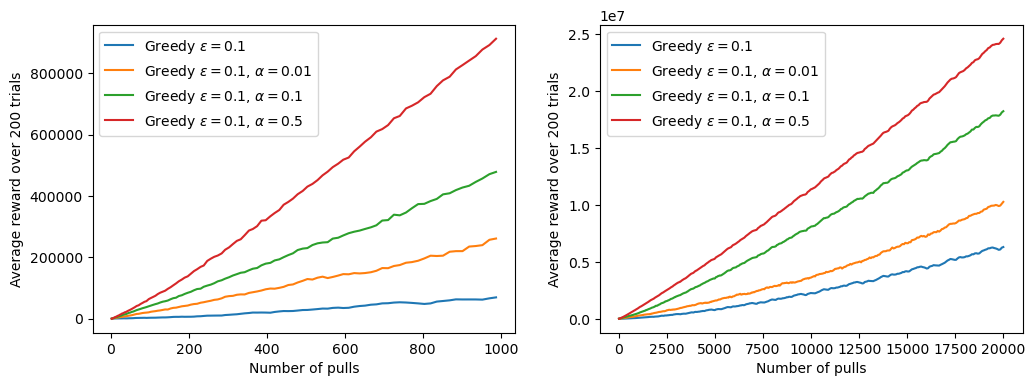

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_avg_rewards(total_pulls, results_drift, 0, 1000)
plt.subplot(122)
plot_avg_rewards(total_pulls, results_drift, 0, np.max(total_pulls))

As we see, the original doesn't hold a candle to this new adaptive strategy.  In this particular example, a more aggressive step size of $\alpha = 0.5$ does the best